# Data Exploitation - Spectral Graph Theory (Cast and Crew)

This notebook is devoted to the further exploitation of the movie graph built on cast and crew co-occurrences. Here we look at the insights provided through the graph Laplacian and its spectral decomposition.

In [1]:
%matplotlib inline
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import collections
import json

In order to do any type of anaysis on our graph, we must first load it! We will be working with the largest component from here on out.

In [2]:
adjacency =  np.load('data/final_project_adjacency_largest_normalized.npy')
n_nodes =  len(adjacency)

Next, we calculate the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

In [3]:
# Calculating the degree matrix D
D = np.diag(np.sum(adjacency, axis=0))

# Calculating the combinatorial graph Laplacian matrix, and storing it in the CSR format
L = D - adjacency
laplacian_combinatorial =  sparse.csr_matrix(L)

# Calculating the inverse degree matrix, with square roots
with scipy.errstate(divide='ignore'):
    D_inv = 1.0/scipy.sqrt(D)
D_inv[scipy.isinf(D_inv)] = 0

# Calculating the normalized graph Laplacian matrix, and storing it in the CSR format
laplacian_normalized = sparse.csr_matrix(D_inv @ L @ D_inv)

In [4]:
laplacian = laplacian_normalized

After this we compute the eigendecomposition of the Laplacian $L = U \Lambda U^\top$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

The eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [5]:
# Calculating the eigenvalues and eivenvectors for the chosen graph Laplacian matrix
evalues, evectors = scipy.linalg.eigh(laplacian.toarray())

# Calculating the ordering of the eigenvalues from smallest to largest
srt = np.argsort(evalues)

# Ordering the eigenvectors and eigenvalues, so that the eigenvalues are ordered in an ascending order
eigenvectors =  evectors[srt]
eigenvalues =  evalues[srt]

assert eigenvectors.shape == (n_nodes, n_nodes)

In [6]:
# Validating that the first eigenvalue (at index 0) is equal to 0 
# In this case the value is not exactly 0, but is a very small real number, due to rounding and 
# other factors that occur during calculation
eigenvalues[0]

8.881784197001252e-16

In [7]:
# Validating that all of our eigenvalues are real numbers; 
# none of them have imaginary components
all(np.imag(eigenvalues) == 0.0)

True

Below we have plotted the eigenvectors $u_0$ for the combinatorial and the normalized Laplacian. 


The first eigenvalue of the combinatorial L is: -3.3416e-16
The first eigenvalue of the normalized L is: 8.8818e-16


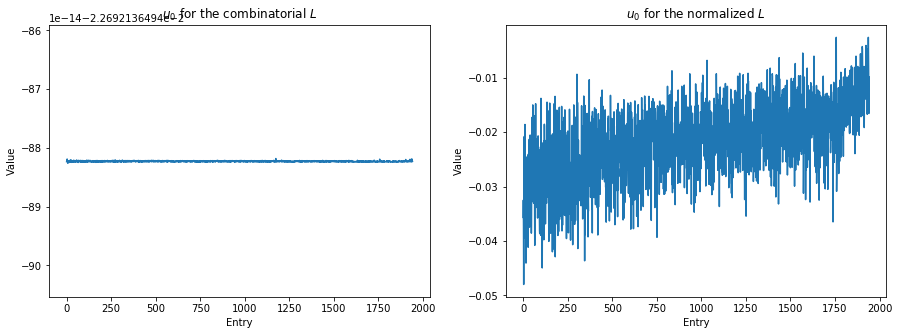

In [8]:
plt.figure(1, figsize = [15,5])

# Plot u_0 for the combinatorial graph Laplacian 

evalues, evectors = scipy.linalg.eigh(laplacian_combinatorial.toarray())

srt = np.argsort(evalues)
eigenvectors =  evectors[srt]
eigenvalues =  evalues[srt]

print("The first eigenvalue of the combinatorial L is: {:0.5}".format(eigenvalues[0]))
plt.subplot(1,2,1)
plt.plot(eigenvectors[:,0])
plt.title('$u_0$ for the combinatorial $L$')
plt.xlabel('Entry')
plt.ylabel('Value')

# Plot u_0 for the normalized graph Laplacian 

evalues, evectors = scipy.linalg.eigh(laplacian_normalized.toarray())

srt = np.argsort(evalues)
eigenvectors =  evectors[srt]
eigenvalues =  evalues[srt]

print("The first eigenvalue of the normalized L is: {:0.5}".format(eigenvalues[0]))
plt.subplot(1,2,2)
plt.plot(eigenvectors[:,0])
plt.title('$u_0$ for the normalized $L$')
plt.xlabel('Entry')
plt.ylabel('Value')


plt.show()

The two plots above behave exactly as expected, the multiplicity of the eigenvalue 0 gives the connectedness of a graph, and the eigenvector $u_0$ corresponding to eigenvalue 0, is an indicator vector of all constants for the combinatorial graph Laplacian.

We will now look at the spectrum of the Laplacian by plotting the eigenvalues

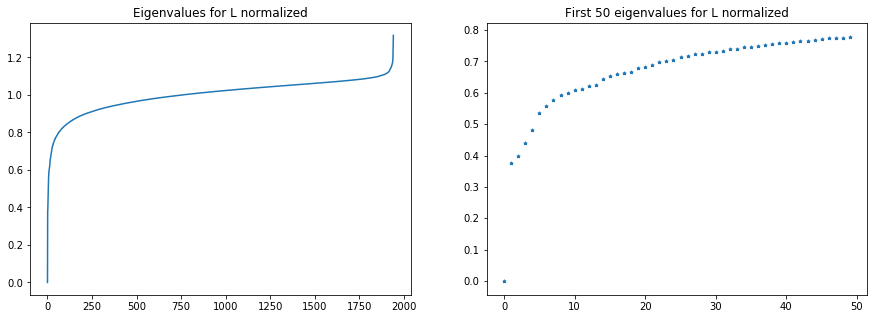

In [9]:
plt.figure(1, figsize = [15,5])

# We are plotting the eigenvalues of the normalized graph Laplacian 
plt.subplot(1,2,1)
plt.plot(eigenvalues)
plt.title('Eigenvalues for L normalized')

# And we are plotting the first 50 eigenvalues of the normalized graph Laplacian 
plt.subplot(1,2,2)
plt.scatter(range(50),eigenvalues[:50], marker="*", s=10)
plt.title('First 50 eigenvalues for L normalized')
plt.show()

In order to gain a better insight into the characteristics of the eigenvalues, we plotted all the eigenvalues and only the first 50. When observing the second plot which shows the first 50 eigenvalues, we can see that the most significant jump in value happens after the first eigenvalue. We know that if data has exactly  k  clear clusters, there will be a gap in the Laplacian spectrum after the  k -th eigenvalue!

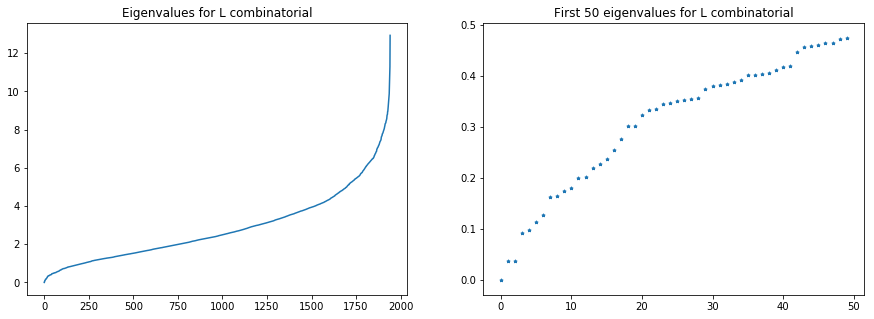

In [10]:
evalues_c, evectors_c = scipy.linalg.eigh(laplacian_combinatorial.toarray())

srt = np.argsort(evalues_c)

eigenvectors_c =  evectors_c[srt]
eigenvalues_c =  evalues_c[srt]
plt.figure(1, figsize = [15,5])
# We are plotting the eigenvalues of the combinatorial graph Laplacian 
plt.subplot(1,2,1)
plt.plot(eigenvalues_c)
plt.title('Eigenvalues for L combinatorial')

# And we are plotting the first 50 eigenvalues of the combinatorial graph Laplacian 
plt.subplot(1,2,2)
plt.scatter(range(50),eigenvalues_c[:50], marker="*", s=10)
plt.title('First 50 eigenvalues for L combinatorial')
plt.show()

Again, in order to gain a better insight into the characteristics of the eigenvalues from the combinatorial Laplacian, we plotted all the eigenvalues and only the first 50. When observing the second plot which shows the first 50 eigenvalues, we can see that the most significant jump in value happens after the first, third or seventh eigenvalue.

In [11]:
print("The graph has {0} connected components.".format(sum(np.isclose(eigenvalues,0))))

The graph has 1 connected components.


The values shown in the graphs above confirm that our graph has one connected component.

## Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

Laplacian eigenmaps (and graph embeddings in general) are used for dimensionality reduction and can help in visualising certain properties.

Graph embeddings are used to learn a mapping from a graph to a vector space, creating a latent vector representation of the graph while preserving relevant graph properties. Graphs are complex structures with nodes and edges and it is often not possible to perform certain operations on these structures. Vector spaces on the other hand can be used in many mathematical, statistical and machine learning operations, and often these operations are a lot simpler and computationally faster than their equivalent graph operations. There has recently been a lot of work and progress in this area, for example the well known application in the natural language processing field - "Word2Vec".

Laplacian Eigenmaps is a method that finds the low dimensional representation of data using a spectral decomposition of the graph Laplacian. Laplacian Eigenmaps outputs coordinate maps that are smooth functions over the original graph.

We will now embed our graph in $d=2$ dimensions with Laplacian eigenmaps, with and without re-normalizing the eigenvectors by the degrees.



In [12]:
# Saving the degree matrix in the CSR format
D_sparse = sparse.csr_matrix(D,dtype=float)
# Calculating the eigenvalues and eigenvectors of the normalized graph Laplacian of the largest component
d_eigvalues_n, d_eigvectors_n = sparse.linalg.eigs(laplacian_normalized, k=3, which='SM')
# Calculating the eigenvalues and eigenvectors of the normalized graph Laplacian of the largest component,
# and re-normalizing by degree
d_eigvalues_ren, d_eigvectors_ren = sparse.linalg.eigs(laplacian_normalized, M=D_sparse, k=3, which='SM')

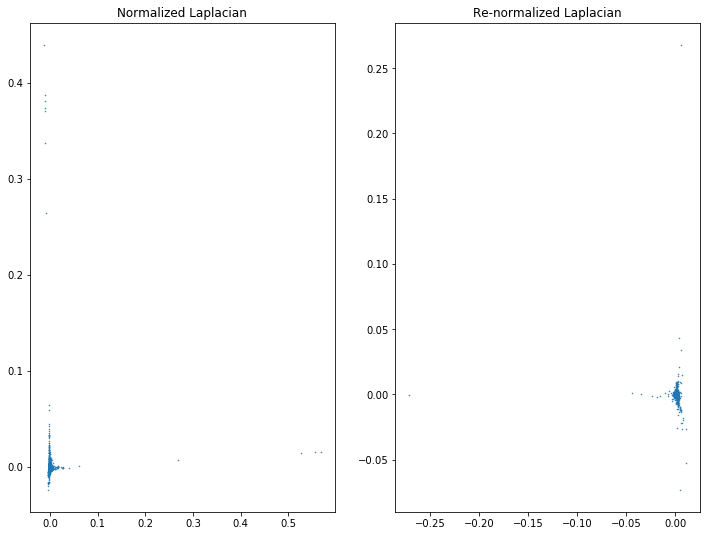

In [13]:
# Plotting the normalized and re-normalized graph Laplacians.
# Note that we are not using the first eigenvector, but the second and third - these correspond to the indexes 1 and 2
# The reason for this is that the first eigenvector is trivial, constant and the values are (approximately) equal to zero
plt.figure(figsize=[12,9])
plt.subplot(121)
plt.plot(np.real(d_eigvectors_n[:,1]),np.real(d_eigvectors_n[:,2]),'.',markersize=1)
plt.title('Normalized Laplacian')
plt.subplot(122)
plt.plot(np.real(d_eigvectors_ren[:,1]),np.real(d_eigvectors_ren[:,2]),'.',markersize=1)
plt.title('Re-normalized Laplacian')
plt.show()

Laplacian eigenmaps should be used to exaggerate clustering, not to provide a faithful representation of nonlinear structure. When observing the plots above, we see that we only get one cluster, along with some tendrils, which does not give us much information about the properties and similarities of the nodes. This is not completely unexpected as we are only plotting in two dimensions.

## Spectral clustering


*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

We decided to explore the distribution of genres in the spectral domain and wanted to see whether we could use spectral clustering as a method to partition this cast and crew co-occurrence graph into clusters that were defined by their respective genres. In order to do this, we must return to the features and labels previously extracted. 

In [14]:
first_movie_features = pd.read_csv('data/refined_imdb_data_project_df.csv')
first_movie_features = first_movie_features.set_index('movie_id').drop('Unnamed: 0', axis = 1)
first_movie_features.head(20)

title  \
movie_id                                                
19995                                          Avatar   
285          Pirates of the Caribbean: At World's End   
206647                                        Spectre   
49026                           The Dark Knight Rises   
49529                                     John Carter   
559                                      Spider-Man 3   
38757                                         Tangled   
99861                         Avengers: Age of Ultron   
767            Harry Potter and the Half-Blood Prince   
209112             Batman v Superman: Dawn of Justice   
1452                                 Superman Returns   
10764                               Quantum of Solace   
58         Pirates of the Caribbean: Dead Man's Chest   
57201                                 The Lone Ranger   
49521                                    Man of Steel   
2454         The Chronicles of Narnia: Prince Caspian   
24428                                    The Avengers   
1865      Pirates of the Caribbean: On Stranger Tides   
41154                                  Men in Black 3   
122917      The Hobbit: The Battle of the Five Armies   

                                                       cast  \
movie_id                                                      
19995     {'Kelly Kilgour', 'James Patrick Pitt', 'Peter...   
285       {'David Meunier', 'David Bailie', 'Keira Knigh...   
206647    {'Harald Windisch', 'Patrice Naiambana', 'Anto...   
49026     {'Patrick Leahy', 'Grant Babbitt', 'Andres Per...   
49529     {'James Purefoy', 'Joseph Billingiere', 'Davoo...   
559       {'Arick Salmea', 'Nick Poltoranin', 'Arne Star...   
38757     {'Mandy Moore', 'Zachary Levi', 'Richard Kiel'...   
99861     {'Robert Downey Jr.', 'Sunny Yeo', 'Brian Scha...   
767       {'Warwick Davis', 'Elarica Gallacher', 'Helen ...   
209112    {'Amy Adams', 'Patrick Leahy', 'Wunmi Mosaku',...   
1452      {'Kal Penn', 'Tristan Lake Leabu', 'Jordana Be...   
10764     {"Brendan O'Hea", 'Daniel Craig', 'Rory Kinnea...   
58        {'David Bailie', 'Keira Knightley', 'Vanessa B...   
57201     {'William Fichtner', 'Alex Knight', 'Devon J. ...   
49521     {'Amy Adams', 'Ayelet Zurer', 'Jadin Gould', '...   
2454      {'Warwick Davis', 'Tilda Swinton', 'Ken Stott'...   
24428     {'Todd Manes', 'Robert Downey Jr.', 'Alicia Si...   
1865      {'Emilia Jones', 'Óscar Jaenada', 'Sebastian A...   
41154     {'Jemaine Clement', 'Nicole Scherzinger', 'Wil...   
122917    {'Kelly Kilgour', 'Simon London', 'Martin Free...   

                                                       crew     budget  \
movie_id                                                                 
19995     {'Janace Tashjian', 'Luke Caska', 'Shannon Mil...  237000000   
285       {'Pat Sandston', 'John Dixon', 'Melissa Muik',...  300000000   
206647    {'Charlie Hounslow', 'Crystal Hadcroft', 'Susa...  245000000   
49026     {'Randle Akerson', 'Kevin Kaska', 'Andrew McEv...  250000000   
49529     {'Kristie Matthiae', 'Sara Riesel', 'Daniel Mi...  260000000   
559       {'Greg Outcalt', 'Suzan Wexler', 'John Fedynic...  258000000   
38757     {'Josh Staub', 'Christopher K. Poplin', 'Jacob...  260000000   
99861     {'Alexandra Byrne', 'Neil Fingleton', 'Ben Vok...  280000000   
767       {'Andrew Ackland-Snow', 'Hermione Byrt', 'J.K....  250000000   
209112    {'Kevin Kaska', 'Wesley Coller', 'David Grimal...  250000000   
1452      {'Scott Mednick', 'Ann Robinson', 'Chris Lee',...  270000000   
10764     {'Robert Wade', 'Marc Forster', 'Matt Chesse',...  200000000   
58        {'Pat Sandston', 'Terry Rossio', 'Camille Frie...  200000000   
57201     {'Kevin Kaska', 'Shannon Mills', 'Peter Oso Sn...  255000000   
49521     {'Aaron Haye', 'Alex McDowell', 'Kevin Kaska',...  225000000   
2454      {'Geoff Stradling', 'Gail Stevens', 'Sim Evan-...  225000000   
24428     {'Daniel P. Rosen', 'Erik Nash', 'Matthew Hart...  220000000   



As shown below, each movie is classified into multiple genres. The genres within this field are not sorted alphabetically, so it can be assumed that they are sorted according to their importance, from highest to lowest. 

In [15]:
first_movie_features.loc[559]['genres']

'[{"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}]'

We opted to keep only the first genre, as it is the one that carries the most value, and to see whether we could use spectral clustering and $k$-means to model these genres. To achieve this, we extracted only this genre and kept this, the movie's unique id and its title, as shown in the dataframe below.

In [16]:
movies_genres = pd.read_csv('data/movies_genres.csv')
movies_genres['id'] = pd.to_numeric(movies_genres['id'])
movies_genres = movies_genres.set_index('id').drop('Unnamed: 0', axis = 1)
movies_genres = movies_genres.groupby(movies_genres.index).first()
movies_genres.drop(['budget','vote_count', 'vote_average'], axis = 1, inplace=True)
movies_genres.rename(index=str, columns={"name": "first_genre"}, inplace=True)
movies_genres.reset_index(inplace=True)
movies_genres['id'] = pd.to_numeric(movies_genres['id'])
movies_genres = movies_genres.set_index('id')
first_genres = pd.merge(first_movie_features, movies_genres, how = 'inner', left_index=True, right_index=True)
first_genres = first_genres[['title', 'first_genre' ]]
first_genres.reset_index(inplace=True, drop = False)
first_genres.head()

index                                     title first_genre
0   19995                                    Avatar      Action
1     285  Pirates of the Caribbean: At World's End   Adventure
2  206647                                   Spectre      Action
3   49026                     The Dark Knight Rises      Action
4   49529                               John Carter      Action

In [17]:
first_genres.to_csv('data/first_genres_largest.csv')

While the TMBD dataset contains 20 possible genres, the genres that occur in our subsampled dataset as the most important genre of each respective film are shown below.

In [18]:
print(set(first_genres['first_genre'].values), len(set(first_genres['first_genre'].values)))

{'Music', 'Science Fiction', 'Fantasy', 'Western', 'Mystery', 'Thriller', 'Family', 'War', 'Crime', 'Horror', 'Comedy', 'History', 'Romance', 'Documentary', 'Drama', 'Animation', 'Adventure', 'Action'} 18


Because of the above, we will be dividing the dataset into 18 dimensions and k = 18.
We embedded our graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$, and tried $k$-means clustering with and without re-normalizing the eigenvectors by the degrees.

In [19]:
d = 18
k = 18
# Calculating the eigenvalues and eigenvectors of the normalized graph Laplacian of the largest component 
# in d dimensions
d_eigenvalues_n, d_eigvectors_n = sparse.linalg.eigs(laplacian_normalized, k=d, which='SM')
# Calculating the eigenvalues and eigenvectors of the normalized graph Laplacian of the largest component,
# and re-normalizing by degree
# in d dimensions
d_eigenvalues_ren, d_eigvectors_ren = sparse.linalg.eigs(laplacian_normalized, M=D_sparse, k=d, which='SM')

# Calculating the labels using K-means on the normalized graph Laplacian eigenvectors
labels_n = KMeans(n_clusters=k, random_state=0).fit(np.real(d_eigvectors_n)).labels_
# Calculating the labels using K-means on the re-normalized graph Laplacian eigenvectors
labels_ren = KMeans(n_clusters=k, random_state=0).fit(np.real(d_eigvectors_ren)).labels_

Below we show the label distributions for the clusterings created with and without re-normalizing the eigenvectors by the degrees.

In [20]:
# Showing the label distribution of K-means using the normalized graph Laplacian
for i in range(k):
    print(i,':',len(np.argwhere(labels_n == i)))

0 : 626
1 : 605
2 : 23
3 : 6
4 : 4
5 : 295
6 : 8
7 : 15
8 : 7
9 : 14
10 : 6
11 : 4
12 : 8
13 : 19
14 : 74
15 : 145
16 : 26
17 : 57


In [21]:
# Showing the label distribution of K-means using the re-normalized graph Laplacian
for i in range(k):
    print(i,':',len(np.argwhere(labels_ren == i)))
    

0 : 1903
1 : 1
2 : 6
3 : 1
4 : 12
5 : 1
6 : 1
7 : 2
8 : 1
9 : 1
10 : 2
11 : 3
12 : 3
13 : 1
14 : 1
15 : 1
16 : 1
17 : 1


Judging from the results obtained with  $k$-means, we decided to proceed using the normalized graph Laplacian eigenvectors. This is due to the fact that when applied to the re-normalized Laplacian, we obtained a clustering that assigned the same label to almost all of the nodes (in this case, label 0).
We then used the computed cluster assignment to reorder the adjacency matrix $A$

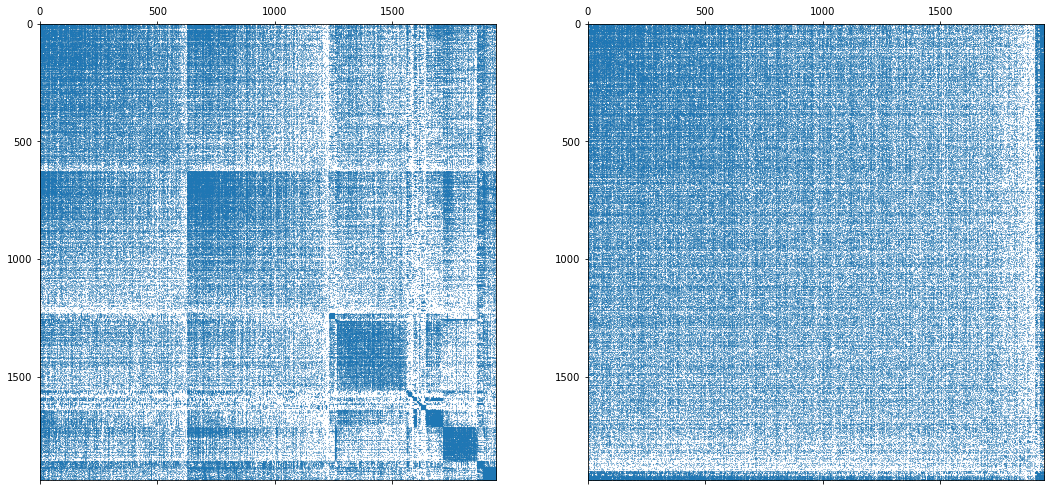

In [22]:
# Ordering the nodes of the largest component by their label calculated using
# K-means on the eigenvectors of the normalized graph Laplacian
idx = sorted(range(len(labels_n)), key=lambda x: labels_n[x])
ordered_adjacency_n = adjacency[:, idx][idx]

# Ordering the nodes of the largest component by their label calculated using
# K-means on the eigenvectors of the re-normalized graph Laplacian
idx = sorted(range(len(labels_ren)), key=lambda x: labels_ren[x])
ordered_adjacency_ren = adjacency[:, idx][idx]

# Plotting the reordered adjacency matricies, 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
# on the left with the K-means labels on the eigenvectors of the normalized graph Laplacian
ax1.spy(ordered_adjacency_n, markersize=0.1)  
# on the right with the K-means labels on the eigenvectors of the re-normalized graph Laplacian
ax2.spy(ordered_adjacency_ren, markersize=0.1)
plt.show()

With any matrix reordering, we expect that the patterns of the matrix will become more visible. After reordering by cluster assignment, the connections will tend to be grouped together so the matrix will seem much more ordered.

After printing the normalized and renormalized adjacency matrices, we observe that the matrix is now ordered in a way that brings nearby points closer together in the matrix, therefore we get a block-diagonal pattern along the matrix with coherent rectangular areas that appear along the diagonal where our strongly connected components are. 

Clear block patterns can now help us count the clusters, estimate cluster overlaps and identify larger and smaller clusters.

As is evident from the plot above, the matrix ordered by their labels calculated using $k$-means on the eigenvectors of the re-normalized graph Laplacian shows only one huge component, consisting of 1903 nodes, and small components that have a maximum 12 nodes within them. This confirms our decision to further work with the normalized graph Laplacian eigenvectors.

Next we compare the cluster assignment from spectral clustering to the ground truth. 
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.

In [23]:
# The labels of the movies according to K-Means
first_genres['labels'] = labels_n
# Here we will write the name of the label assigned to the node according to majority voting among nodes of the cluster
first_genres['k-means genre'] = ''

In order to attach a specific genre to each cluster, we looked at the ground truth labels in each cluster, determined which ones were the most common, and then assigned this label to the cluster overall.

In [24]:
# Iterating through all clusters
for j in range(0, k):
    # Get the nodes in that cluster
    idx = [i for i in range(len(labels_n)) if labels_n[i] == j]
    # Get the first genres of the nodes in the cluster
    l = list(first_genres[first_genres.index.isin(idx)].first_genre)
    # Create a counter using this data, effectively counting the occurence of each genre in the cluster
    counter = collections.Counter(l)
    print("Top genre in cluster: ", counter.most_common(1)[0][0])
    print("Genres in cluster: ", counter.most_common())
    for node in idx:
        # For each node in the cluster, assign the genre that is the most common in this cluster
        first_genres.loc[ first_genres.index == node, 'k-means genre'] = counter.most_common(1)[0][0]
    print("Number of nodes in the cluster:", len(idx))
    print("\n")
    

Top genre in cluster:  Drama
Genres in cluster:  [('Drama', 189), ('Action', 109), ('Comedy', 91), ('Adventure', 60), ('Crime', 41), ('Thriller', 33), ('Fantasy', 25), ('Romance', 13), ('Science Fiction', 11), ('Animation', 11), ('Horror', 10), ('Family', 6), ('Mystery', 6), ('History', 5), ('War', 5), ('Documentary', 5), ('Western', 3), ('Music', 3)]
Number of nodes in the cluster: 626


Top genre in cluster:  Action
Genres in cluster:  [('Action', 180), ('Drama', 98), ('Horror', 70), ('Adventure', 63), ('Thriller', 42), ('Comedy', 35), ('Science Fiction', 31), ('Crime', 28), ('Fantasy', 24), ('Mystery', 13), ('Romance', 7), ('War', 4), ('Family', 3), ('Western', 3), ('Animation', 3), ('History', 1)]
Number of nodes in the cluster: 605


Top genre in cluster:  Comedy
Genres in cluster:  [('Comedy', 14), ('Action', 4), ('Animation', 2), ('Romance', 2), ('Fantasy', 1)]
Number of nodes in the cluster: 23


Top genre in cluster:  Adventure
Genres in cluster:  [('Adventure', 6)]
Number of 

In [25]:
accuracy = 100 * len(first_genres[first_genres.first_genre == first_genres['k-means genre']]) / len(first_genres)
print('Percentage of correctly labeled nodes: ', accuracy)

Percentage of correctly labeled nodes:  38.51699279093718


As can be seen above from the accuracy, the $k$-means algorithm was not highly successful in assigning the movie genre labels. This is in part due to the subsampling, and in part possible due to the fact that $k$-means is not the ideal algorithm for recognizing labels in this dataset. Another problem is the number of genre combinations in the ground truth dataset, which is very high compared to the number of nodes in our subset.

In [26]:
collections.Counter(list(first_genres['first_genre'])).most_common()

[('Action', 392),
 ('Drama', 376),
 ('Comedy', 359),
 ('Adventure', 190),
 ('Horror', 118),
 ('Thriller', 95),
 ('Crime', 85),
 ('Animation', 77),
 ('Fantasy', 68),
 ('Science Fiction', 55),
 ('Romance', 43),
 ('Family', 25),
 ('Mystery', 22),
 ('War', 10),
 ('History', 8),
 ('Western', 7),
 ('Music', 6),
 ('Documentary', 6)]

In [27]:
collections.Counter(list(first_genres['k-means genre'])).most_common()

[('Drama', 777),
 ('Action', 703),
 ('Comedy', 330),
 ('Animation', 88),
 ('Horror', 26),
 ('Adventure', 14),
 ('Science Fiction', 4)]

As can be seen from the listed original labels and the labels obtained from the cluster by majority voting, the algorithm assigned only 7 different genre labels to the clusters it created. This was in part due to the fact that some of the genres are highly underrepresented in our subsample. Additionally, many of the movies that were wrongly labeled most probably contain the genre somewhere in the list of their ground truth list labels, which we had to summarize to only one as explained previously.

Other than that, it seems that the clustering was performed relatively successfully, as all of the genres that were very represented in the original dataset labels, are still very prominent in the labels that were given by the clustering algorithm.



The following plots show first the cluster assignment, then the ground truth first genre labels, and the third plot shows the genres assigned with $k$-means.

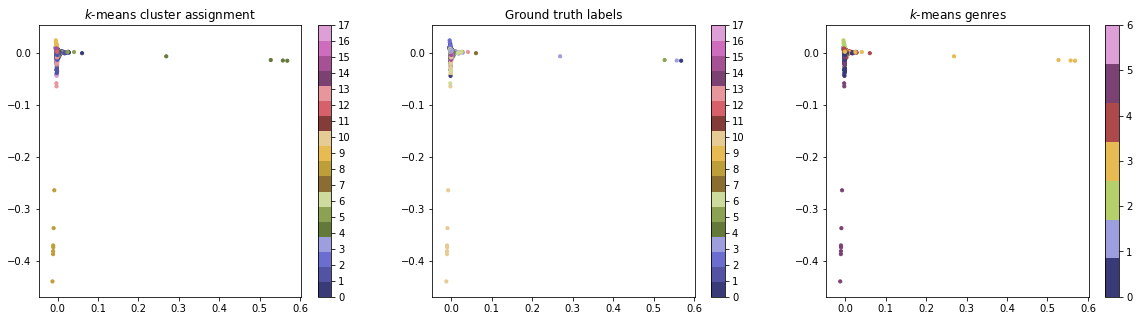

In [28]:
plt.figure(figsize=[20,5])

plt.subplot(1,3,1)
plt.scatter(np.real(d_eigvectors_n[:,1]), np.real(d_eigvectors_n[:,2]),c=labels_n,cmap=plt.cm.get_cmap('tab20b', k),s=10)
plt.colorbar(ticks=np.linspace(0,k-1,k))
plt.title('$k$-means cluster assignment')

plt.subplot(1,3,2)
_, labels_k = np.unique(first_genres['first_genre'].values, return_inverse=True)
plt.scatter(np.real(d_eigvectors_n[:,1]), np.real(d_eigvectors_n[:,2]),c=labels_k,cmap=plt.cm.get_cmap('tab20b', k),s=10)
plt.colorbar(ticks=np.linspace(0,k-1,k))
plt.title('Ground truth labels')

plt.subplot(1,3,3)
_, labels_k = np.unique(first_genres['k-means genre'].values, return_inverse=True)
plt.scatter(np.real(d_eigvectors_n[:,1]), np.real(d_eigvectors_n[:,2]),c=labels_k,cmap=plt.cm.get_cmap('tab20b', 7),s=10)
plt.colorbar(ticks=np.linspace(0,7-1,7))
plt.title('$k$-means genres')

plt.show()

As can be seen from these plots, it is hard to distinguish between different label assignments due to the shape of the 2D embedding computed with Laplacian eigenmaps. For this reason, we decided to shift our focus from the cast and crew graph and to explore the genre distributions using a graph based on keyword co-occurrences. The implementation of this can be found in the *Data Explotitation - Keyword co-occurrence graph* Notebook.